### Load The Dataset

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier  # or any other classifier you've trained

# Load test data
colon_df = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\aug_train_processed.csv')
colon_df.head()
test = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\aug_test_processed.csv')
answers = np.load('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Raw\\answer.npy')
X_test = test.drop('id', axis=1)  # Drop 'id' column as it's not used for predictions



In [12]:
from imblearn.under_sampling import TomekLinks
# declare feature vector and target variable

X = colon_df.drop(['Response','id'], axis=1)
y = colon_df['Response']
resampled_df = pd.concat([X, y], axis=1)
resampled_df.head()


,Gender,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Age_Group,Annual_Premium_Treated,Region_Category,Response
0,1,1,1,0,152.0,16,2,2630.0,2,0
1,1,0,0,1,26.0,135,0,43327.0,0,0
2,0,0,0,1,124.0,253,1,35841.0,0,0
3,0,0,1,0,152.0,69,2,27645.0,0,0
4,1,1,1,0,152.0,211,2,29023.0,0,0


In [13]:
colon_df=resampled_df

### K_means ++ 

Choosing K-means++ for a large, imbalanced dataset is advantageous due to:

- Improved Initialization: K-means++ enhances centroid initialization, crucial for large datasets where efficient convergence is vital.

- Handling Imbalance: It mitigates biases towards majority classes, ensuring representative clusters for both minority and majority classes.

- Computational Efficiency: K-means++ reduces computational burden, accelerating convergence and minimizing memory requirements, suitable for large datasets.

- Robustness to Noise: By starting with well-distributed initial centroids, K-means++ is robust to noise and outliers, enhancing the quality of clustering results.

- Interpretability and Insights: Its robustness and efficiency contribute to meaningful insights, enabling effective data exploration and decision-making.

### The Elbow Method
The Elbow method is a technique used to determine the optimal number of clusters in a dataset for clustering algorithms like K-means++.

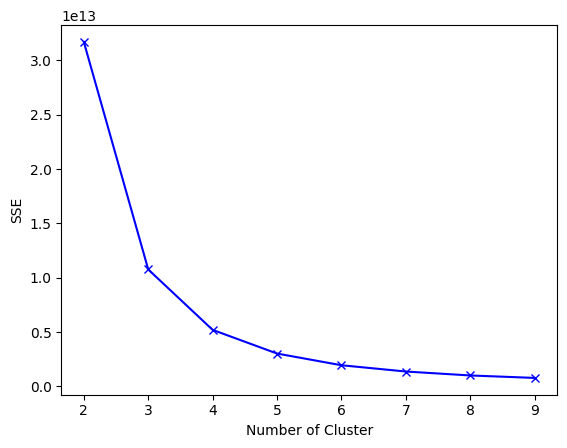

In [14]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse={}
for k in range(2,10):
  kmeans=KMeans(n_clusters=k,init='random',max_iter=500).fit(colon_df)
  sse[k]=kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()),'bx-')
plt.xlabel("Number of Cluster")
plt.ylabel("SSE")
plt.savefig("elbow_method.png")

In [15]:
num_of_clusters=5

In [16]:
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

def apply_dynamic_smote(X, y, cluster_labels, k_neighbors_default=5):
    unique_clusters = np.unique(cluster_labels)
    resampled_data = {}
    smote = SMOTE(sampling_strategy='auto', random_state=2020)

    for cluster in unique_clusters:
        # Select data for the current cluster
        subset_X = X[cluster_labels == cluster]
        subset_y = y[cluster_labels == cluster]
        
        # Check if the subset_y contains more than one class
        if len(np.unique(subset_y)) > 1:
            # Adjust k_neighbors based on the cluster size
            k_neighbors = min(k_neighbors_default, len(subset_y) // 2 - 1)  # Avoid too large k for small clusters
            smote.set_params(k_neighbors=k_neighbors)

            X_resampled, y_resampled = smote.fit_resample(subset_X, subset_y)
        else:
            # If only one class is present, use the original data
            X_resampled, y_resampled = subset_X, subset_y
        
        # Combine resampled features and target variable
        resampled_subset = pd.concat([pd.DataFrame(X_resampled, columns=subset_X.columns),
                                      pd.Series(y_resampled, name='Response')],
                                     axis=1)
        resampled_data[cluster] = resampled_subset
    
    return resampled_data


### Davies-Bouldin Index

In [17]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin = davies_bouldin_score(colon_df, kmeans.labels_)
print(f'Davies-Bouldin Index: {davies_bouldin}')

Davies-Bouldin Index: 0.46580661798040585


### Alinski-Harabasz Index

In [18]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz = calinski_harabasz_score(colon_df, kmeans.labels_)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

Calinski-Harabasz Index: 5515800.093210823


- The Davies-Bouldin Index and Calinski-Harabasz Index are both metrics used to evaluate the quality of clustering. A lower Davies-Bouldin Index and a higher Calinski-Harabasz Index indicate better clustering performance.

- In our case, we have a Davies-Bouldin Index of approximately 0.48, which is relatively low, and a Calinski-Harabasz Index of approximately 1,230,443.78, which is quite high. These values suggest that the clustering is good, as they indicate that the clusters are well-separated and internally cohesive.



In [19]:
X_train_full = colon_df.drop('Response', axis=1)
#X_train_full = X_train_full.drop('id', axis=1)
y_train_full = colon_df['Response']

# Initialize and fit K-Means model
num_clusters = 5  # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters,init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_train_full)

# Apply SMOTE considering single-class clusters
resampled_data = apply_dynamic_smote(X_train_full, y_train_full, cluster_labels)

# Combine all resampled data into a single DataFrame
resampled_df = pd.concat(resampled_data.values(), ignore_index=True)



In [20]:
# Save the DataFrame to a CSV file
resampled_df.to_csv('smote_balanced_dataset.csv', index=False)

### Visulization and Distribution

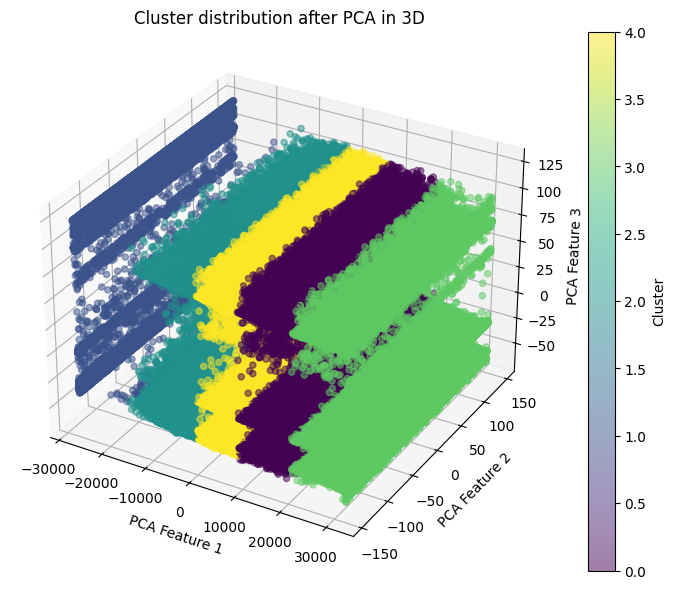

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting module
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# Perform PCA
pca = PCA(n_components=3)  # Update number of components to 3 for 3D plot
D_pca = pca.fit_transform(colon_df)

# Plot the cluster distribution after PCA in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(D_pca[:, 0], D_pca[:, 1], D_pca[:, 2], c=kmeans.labels_, cmap='viridis', alpha=0.5)

# Add labels and title
ax.set_title("Cluster distribution after PCA in 3D")
ax.set_xlabel("PCA Feature 1")
ax.set_ylabel("PCA Feature 2")
ax.set_zlabel("PCA Feature 3")

# Add color bar
legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster')

plt.show()


In [22]:
X_train = resampled_df.drop('Response', axis=1)
y_train = resampled_df['Response']
X_train.head()

,Gender,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Age_Group,Annual_Premium_Treated,Region_Category
0,1,0,0,1,26.0,135,0,43327.0,0
1,0,1,1,0,152.0,12,2,47665.0,0
2,1,1,1,0,152.0,34,2,40044.0,0
3,1,0,0,1,26.0,254,0,40987.0,0
4,0,1,0,0,124.0,270,0,45493.0,0


In [23]:
# Predict class labels for the test set
classifier = RandomForestClassifier(
       random_state=34, max_depth=2, criterion='entropy'
)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, random_state=34)

In [24]:
# Predict class labels for the test set
predicted_labels = classifier.predict(X_test)

# If you're interested in probabilities (e.g., for ROC AUC score)
#predicted_probs = classifier.predict_proba(X_test)[:, 1]  # Assuming positive class probabilities are in the second column

In [25]:
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score
try:
    accuracy = balanced_accuracy_score(answers, predicted_labels)
    recall = recall_score(answers, predicted_labels)
    geomean= geometric_mean_score(answers, predicted_labels)
    roc_auc= roc_auc_score(answers, predicted_labels)
    f1 = f1_score(answers, predicted_labels)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"GeoMean: {geomean}")
    print(f"f1_score: {f1}")
    print(f"roc_auc_score: {roc_auc}")
except Exception as e:
    print("Error calculating metrics:", str(e))


Accuracy: 0.8159057838692889
Recall: 0.9173818068341395
GeoMean: 0.8095707905517564
f1_score: 0.5435300099378307
roc_auc_score: 0.8159057838692887


In [26]:
# Initial class distribution
print("Initial Class Distribution before using SMOTE:\n", colon_df['Response'].value_counts(normalize=True))

# Assuming you've generated synthetic samples or performed some sampling based on clusters
# Updated class distribution
# This would depend on how you've chosen to address the imbalance post-clustering
print("Updated Class Distribution after using SMOTE:\n",resampled_df['Response'].value_counts(normalize=True))


Initial Class Distribution before using SMOTE:
 Response
0    0.835976
1    0.164024
Name: proportion, dtype: float64
Updated Class Distribution after using SMOTE:
 Response
0    0.5
1    0.5
Name: proportion, dtype: float64


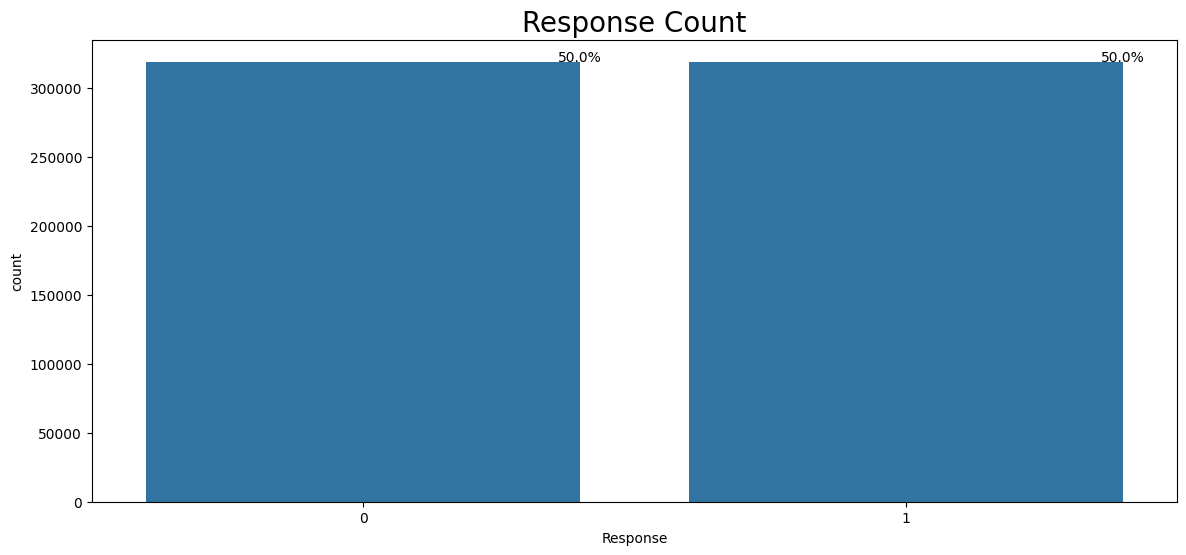

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.figure(figsize=(14,6))
total = float(len(resampled_df))
ax = sns.countplot(x='Response', data=resampled_df)
plt.title('Response Count', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()